In [1]:
import numpy as np

import json
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
import keras.backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('data/sentipolc_word_index.json', 'r') as f:
    word_index = json.load(f)

In [3]:
with open('data/words.tsv', 'w') as f:
    for w,_ in word_index.items():
        f.write('{}\n'.format(w))

In [4]:
words = [w for w,_ in word_index.items()]

In [5]:
data = np.load('data/sentipolc_seq.npz')

x_train = data['x_train']
y_train = data['y_train']

x_test = data['x_test']
y_test = data['y_test']

Check the max length of the text

In [6]:
max_len_seq = max([len(x) for x in x_train])
print('max len seq {}'.format(max_len_seq))
max_idx = max(word_index.values())
print('max id {}'.format(max_idx))

max len seq 40
max id 15204


In [7]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=max_len_seq, padding='post')
x_test_pad = sequence.pad_sequences(x_test, maxlen=max_len_seq, padding='post')

In [8]:
x_train_pad.shape

(7410, 40)

In [9]:
x_train_pad[:2]

array([[15204,    11,   980,    15, 15204, 15204,    22, 15204, 15204,
          109,    10, 15204,    34,    33, 15204, 15204, 15204,    47,
        15204,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [15204, 15204,  1381,   474, 15204, 15204, 15204,    47, 15204,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]], dtype=int32)

# Define metrics

In [10]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
     how many selected items are relevant.
      """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))		
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))		
    precision = true_positives / (predicted_positives + K.epsilon())		
    return precision

In [11]:
def recall(y_true, y_pred):
    """Recall metric.
 
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split_train_test = StratifiedShuffleSplit(1,test_size=0.2, random_state=123456)

for train, test in split_train_test.split(x_train_pad, y_train):
    x_train_pad_split, y_train_pad_split = x_train_pad[train], y_train[train]
    x_val_pad_split, y_val_pad_split = x_train_pad[test], y_train[test]

In [13]:
callbacks = [
    TensorBoard(histogram_freq=1, batch_size=128, embeddings_freq=1),
    ReduceLROnPlateau(patience=2, verbose=1)
]

Instructions for updating:
Use the retry module or similar alternatives.


In [14]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_idx+1, output_dim=100, input_length=max_len_seq))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', precision, recall])
    
    return model

In [15]:
model = build_model()
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           1520500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 32)            10272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1650      
___________________________________________________________

In [17]:
history = model.fit(x_train_pad_split, y_train_pad_split, validation_data=(x_val_pad_split, y_val_pad_split),
                    batch_size=128, validation_split=0.2, epochs=10)

Train on 5928 samples, validate on 1482 samples
Epoch 1/10
5928/5928 [==============================] - 4s 678us/step - loss: 0.6323 - acc: 0.6837 - precision: 0.0048 - recall: 0.0062 - val_loss: 0.6176 - val_acc: 0.6883 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
5928/5928 [==============================] - 3s 537us/step - loss: 0.6117 - acc: 0.6883 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6101 - val_acc: 0.6883 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
5928/5928 [==============================] - 3s 511us/step - loss: 0.5522 - acc: 0.6945 - precision: 0.2883 - recall: 0.0394 - val_loss: 0.6240 - val_acc: 0.6950 - val_precision: 0.5370 - val_recall: 0.0995
Epoch 4/10
5928/5928 [==============================] - 3s 584us/step - loss: 0.3961 - acc: 0.8281 - precision: 0.8002 - recall: 0.6146 - val_loss: 0.6952 - val_acc: 0.6633 - val_precision: 0.4549 - val_recall: 0.3912
Epoch 5/10
5928/5928 [==============================] - 

In [19]:
import matplotlib.pyplot as plt

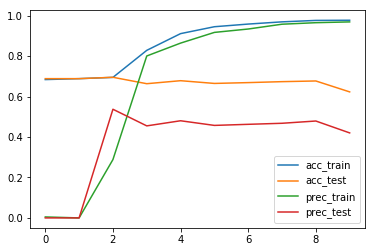

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.legend(['acc_train', 'acc_test', 'prec_train', 'prec_test'], loc='lower right')

## Evaluate on the test set

In [17]:
callbacks = [
    TensorBoard(histogram_freq=0, batch_size=128, embeddings_freq=1),
]

In [18]:
model = build_model()

history = model.fit(x_train_pad, y_train, batch_size=128, epochs=3, callbacks=callbacks)

Epoch 1/3
7410/7410 [==============================] - 4s 490us/step - loss: 0.6372 - acc: 0.6721 - precision: 0.0170 - recall: 0.0353
Epoch 2/3
7410/7410 [==============================] - 3s 446us/step - loss: 0.6039 - acc: 0.6883 - precision: 0.0086 - recall: 4.7983e-04
Epoch 3/3
7410/7410 [==============================] - 3s 446us/step - loss: 0.5158 - acc: 0.7356 - precision: 0.6726 - recall: 0.2837


In [19]:
model.evaluate(x_test_pad, y_test)

2000/2000 [==============================] - 0s 180us/step


[0.5887644205093384, 0.6915, 0.2817197949886322, 0.3031908062696457]

In [20]:
#model.save('models/sentipolc_word_cnn.hdf5')

# Overall metrics

In [21]:
from sklearn import metrics

In [22]:
predictions = model.predict_classes(x_train_pad, batch_size=128)
tn, fp, fn, tp = metrics.confusion_matrix(y_train, predictions).ravel()

recall = tp/(tp+fp)
precision = tp/(tp+fn)
f1 = metrics.f1_score(y_train,predictions)

print ('precision: {}'.format(precision), '\nrecall: {}'.format(recall), '\nf1: {}'.format(f1))

precision: 0.7194805194805195 
recall: 0.8044530493707648 
f1: 0.759597806215722
